In [1]:
import pandas as pd
import numpy as np
import sklearn.neighbors
from collections import OrderedDict

In [2]:
import sklearn.linear_model
import sklearn.tree
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV

In [3]:
# import itertools
# from gensim.models.word2vec import Text8Corpus
# from glove import Corpus, Glove

In [49]:
x_train_df = pd.read_csv('x_train.csv')
y_train_df = pd.read_csv('y_train.csv')
x_test_df = pd.read_csv('x_test.csv')

In [50]:
tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

# Load GloVe 

In [6]:
word_embeddings = pd.read_csv('glove.6B.50d.txt.zip',header=None, sep=' ', index_col=0, nrows=100000, compression='zip', encoding='utf-8', quoting=3)

In [7]:
# Build a dict that will map from string word to 50-dim vector
word_list = word_embeddings.index.values.tolist()
word2vec = OrderedDict(zip(word_list, word_embeddings.values))

In [8]:
word2vec['of']

array([ 0.70853  ,  0.57088  , -0.4716   ,  0.18048  ,  0.54449  ,
        0.72603  ,  0.18157  , -0.52393  ,  0.10381  , -0.17566  ,
        0.078852 , -0.36216  , -0.11829  , -0.83336  ,  0.11917  ,
       -0.16605  ,  0.061555 , -0.012719 , -0.56623  ,  0.013616 ,
        0.22851  , -0.14396  , -0.067549 , -0.38157  , -0.23698  ,
       -1.7037   , -0.86692  , -0.26704  , -0.2589   ,  0.1767   ,
        3.8676   , -0.1613   , -0.13273  , -0.68881  ,  0.18444  ,
        0.0052464, -0.33874  , -0.078956 ,  0.24185  ,  0.36576  ,
       -0.34727  ,  0.28483  ,  0.075693 , -0.062178 , -0.38988  ,
        0.22902  , -0.21617  , -0.22562  , -0.093918 , -0.80375  ])

In [9]:
## Show some examples
n_words = len(word2vec.keys())
print("word2vec['london'] = ")
print(word2vec['london'])

print("word2vec['england'] = ")
print(word2vec['england'])

word2vec['london'] = 
[ 0.032886   0.99637   -0.6975    -0.58375    0.053403  -0.35758
 -0.96735   -0.048156  -0.23417   -0.31642   -0.080246   0.0075121
 -0.69211   -0.19357    0.040528   0.74492    0.079019  -0.13893
 -1.5938     0.33824    2.5535     0.87576   -0.1597     0.85763
 -0.68158   -1.3948     0.13189    0.10129   -0.7461     0.67386
  2.5619    -0.19922    0.76751   -0.4867     0.39738   -0.6253
  0.63504   -0.1989    -0.0953    -0.22472    0.61698   -0.21968
  0.2584    -0.39371    0.47571    0.57736   -0.55713   -0.6259
  0.60789   -0.30978  ]
word2vec['england'] = 
[-3.6165e-01 -1.0607e-01 -1.1168e+00 -6.7270e-01 -1.6521e-01  6.8828e-02
 -1.1727e+00  7.1667e-01  1.6573e-01 -7.5759e-01 -1.4659e-01  3.5785e-01
 -6.9141e-01 -1.2047e+00  1.5224e-01  6.3566e-01  8.7442e-01 -6.1517e-01
 -1.7471e+00  3.5292e-01  2.2251e-02  3.8990e-01  2.0703e-02  7.4169e-01
  2.4097e-03 -1.3529e+00  5.8844e-01 -4.2970e-01 -5.1740e-01  6.2258e-01
  2.8153e+00  3.0152e-01  7.8742e-01 -7.9597e-

In [10]:
## Try some analogies
def analogy_lookup(a1, a2, b1):
    
    target_vec = word2vec[a2] - word2vec[a1] + word2vec[b1]
    knn = sklearn.neighbors.NearestNeighbors(n_neighbors=7, metric='euclidean', algorithm='brute')
    knn.fit(word_embeddings.values)
    dists, indices = knn.kneighbors(target_vec[np.newaxis,:])
    print("Query: %s:%s -> %s:____" % (a1, a2, b1))
    for ii, vv in enumerate(indices[0]):
        print("   %20s  at dist %.3f" % (word_list[vv], dists[0,ii]))


In [11]:
analogy_lookup('england', 'london', 'france')
analogy_lookup('england', 'london', 'germany')
analogy_lookup('england', 'london', 'japan')
analogy_lookup('england', 'london', 'indonesia')
analogy_lookup('swim', 'swimming', 'run')

Query: england:london -> france:____
                  paris  at dist 3.408
                 france  at dist 4.349
               brussels  at dist 4.657
                 french  at dist 4.711
                 berlin  at dist 5.369
                 vienna  at dist 5.389
             luxembourg  at dist 5.411
Query: england:london -> germany:____
                 berlin  at dist 4.269
                germany  at dist 4.349
                 german  at dist 4.760
              frankfurt  at dist 4.913
                 moscow  at dist 5.014
                 vienna  at dist 5.062
                 warsaw  at dist 5.201
Query: england:london -> japan:____
                  tokyo  at dist 3.900
                  japan  at dist 4.349
               japanese  at dist 4.569
               shanghai  at dist 4.941
                  seoul  at dist 5.299
                beijing  at dist 5.348
              singapore  at dist 5.498
Query: england:london -> indonesia:____
              singapore  at di

# Data preprocessing

In [27]:
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

In [28]:
x_train_df_2 = x_train_df['text'].str.split(" ", expand = True)
tokenizer = RegexpTokenizer(r'\w+')
train2 = x_train_df['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [51]:
# train2

In [34]:
def word2vec2(word):
    try:
        return(word2vec[word])
    except:
        return None

In [36]:
def sen2vec(sen):
    # sen: a list of words
    l1 = [word2vec2(item) for item in sen]  
    l1 = [item for item in l1 if item is not None]
    return [np.mean([item[i] for item in l1]) for i in range(50)]

In [39]:
tr_data = [sen2vec(sen) for sen in train2]

In [56]:
# Similar to test data
x_test_df_2 = x_test_df['text'].str.split(" ", expand = True)
tokenizer = RegexpTokenizer(r'\w+')
test2 = x_test_df['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
te_data = [sen2vec(sen) for sen in test2]

In [52]:
# print(pd.DataFrame(tr_data))

# Logistic Regression

In [79]:
param_grid = [
  {'C': np.logspace(-9, 6, 20)}
 ]

lrm = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=10, return_train_score=True ).fit(tr_data, y_train_df.values.ravel())



In [80]:
pd.DataFrame(lrm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.011169,0.003487,0.001627,0.001552,1e-09,{'C': 1e-09},0.658333,0.650000,0.629167,0.675000,...,0.674537,0.679630,0.699537,0.707407,0.689815,0.712963,0.694907,0.710648,0.692917,0.013608
1,0.011172,0.001636,0.001277,0.000361,6.15848e-09,{'C': 6.158482110660254e-09},0.658333,0.650000,0.629167,0.675000,...,0.674537,0.679630,0.699537,0.707407,0.689815,0.712963,0.694907,0.710648,0.692917,0.013608
2,0.010864,0.001024,0.001439,0.000316,3.79269e-08,{'C': 3.792690190732254e-08},0.658333,0.650000,0.629167,0.675000,...,0.674537,0.679630,0.699537,0.707407,0.689815,0.712963,0.694907,0.710648,0.692917,0.013608
3,0.015086,0.004923,0.001647,0.000749,2.33572e-07,{'C': 2.3357214690901212e-07},0.658333,0.650000,0.629167,0.675000,...,0.674537,0.679630,0.699537,0.707407,0.689815,0.712963,0.695833,0.710648,0.693009,0.013625
4,0.011746,0.004395,0.001045,0.000056,1.43845e-06,{'C': 1.438449888287663e-06},0.662500,0.650000,0.637500,0.675000,...,0.675463,0.680093,0.700463,0.707870,0.690278,0.712963,0.694907,0.710648,0.693194,0.013582
5,0.010301,0.000740,0.001062,0.000088,8.85867e-06,{'C': 8.858667904100832e-06},0.666667,0.650000,0.641667,0.687500,...,0.676852,0.682407,0.699074,0.706944,0.691204,0.715278,0.694907,0.711574,0.694583,0.012679
6,0.012697,0.001149,0.001229,0.000246,5.45559e-05,{'C': 5.4555947811685143e-05},0.687500,0.670833,0.654167,0.695833,...,0.692130,0.695833,0.707407,0.708796,0.701852,0.713426,0.707407,0.712037,0.702963,0.007647
7,0.015135,0.003812,0.001420,0.000339,0.000335982,{'C': 0.0003359818286283781},0.737500,0.695833,0.687500,0.654167,...,0.712500,0.710648,0.712037,0.712963,0.713426,0.718056,0.708796,0.712963,0.711157,0.003764
8,0.011742,0.000941,0.001102,0.000290,0.00206914,{'C': 0.00206913808111479},0.754167,0.737500,0.695833,0.650000,...,0.723148,0.723611,0.719444,0.719907,0.720370,0.727315,0.722685,0.720370,0.720787,0.003565
9,0.012691,0.001184,0.001047,0.000103,0.0127427,{'C': 0.012742749857031348},0.775000,0.745833,0.720833,0.704167,...,0.747222,0.747685,0.742593,0.737963,0.744444,0.749537,0.745370,0.744444,0.744074,0.003420


In [73]:
# print(lrm.cv_results_)

In [74]:
yproba1_test_lgt = lrm.predict(te_data)
np.savetxt('yproba1_testlgt.txt', yproba1_test_lgt)

In [81]:
lgt_re = lrm.cv_results_

In [82]:
C_grid = np.logspace(-9, 6, 20)
C_log = np.log10(C_grid)

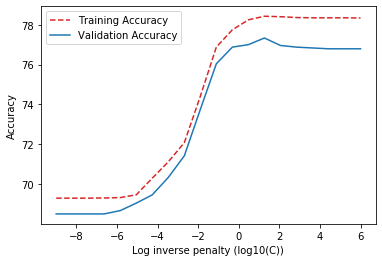

In [83]:
fig, ax = plt.subplots()
ax.plot(C_log,lgt_re.get("mean_train_score")*100, label='Training Accuracy', color="tab:red", ls='--')
ax.plot(C_log,lgt_re.get("mean_test_score")*100, label='Validation Accuracy', color="tab:blue")
plt.xlabel('Log inverse penalty (log10(C))')
plt.ylabel('Accuracy')
# plt.ylim([0.4, 0.5] );

ax.legend()
plt.show()

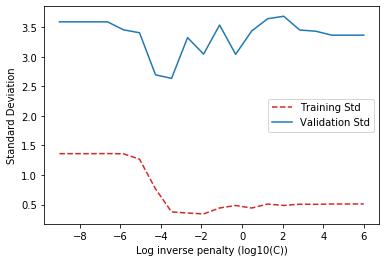

In [84]:
fig, ax = plt.subplots()
ax.plot(C_log,lgt_re.get("std_train_score")*100, label='Training Std', color="tab:red", ls='--')
ax.plot(C_log,lgt_re.get("std_test_score")*100, label='Validation Std', color="tab:blue")
plt.xlabel('Log inverse penalty (log10(C))')
plt.ylabel('Standard Deviation')
# plt.ylim([0.0, 0.7]);

ax.legend()
plt.show()


# MLP

In [109]:
param_mlp = [
  {'alpha': np.logspace(-5, 3, 20)}
 ]


In [110]:
mlpclf = GridSearchCV(MLPClassifier(activation = 'logistic', solver='lbfgs'), param_mlp, cv=10, return_train_score=True ).fit(tr_data, y_train_df.values.ravel())


In [111]:
pd.DataFrame(mlpclf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.085071,0.152364,0.004412,0.007295,1e-05,{'alpha': 1e-05},0.758333,0.779167,0.695833,0.708333,...,0.855093,0.847222,0.843519,0.855556,0.818519,0.855556,0.833333,0.820833,0.838935,0.013645
1,1.126358,0.277399,0.001950,0.000393,2.63665e-05,{'alpha': 2.6366508987303556e-05},0.766667,0.762500,0.687500,0.750000,...,0.839352,0.844444,0.844444,0.866667,0.835648,0.838889,0.849537,0.824074,0.839259,0.012670
2,0.878300,0.281850,0.001867,0.000309,6.95193e-05,{'alpha': 6.951927961775606e-05},0.762500,0.779167,0.683333,0.754167,...,0.840278,0.859722,0.847685,0.852778,0.843519,0.835185,0.668519,0.836111,0.826250,0.053200
3,0.976856,0.063808,0.001905,0.000312,0.000183298,{'alpha': 0.00018329807108324357},0.770833,0.766667,0.708333,0.737500,...,0.833333,0.843519,0.839352,0.827778,0.856019,0.832407,0.845833,0.823148,0.837037,0.009082
4,0.950075,0.088381,0.001849,0.000649,0.000483293,{'alpha': 0.0004832930238571752},0.783333,0.795833,0.720833,0.716667,...,0.857407,0.840741,0.834259,0.820370,0.837037,0.827778,0.836111,0.832870,0.834120,0.009973
5,0.927606,0.072981,0.002282,0.001152,0.00127427,{'alpha': 0.0012742749857031334},0.733333,0.770833,0.708333,0.737500,...,0.845833,0.841667,0.849537,0.841667,0.834259,0.839352,0.838426,0.830093,0.838241,0.007756
6,0.940745,0.081034,0.001990,0.000625,0.00335982,{'alpha': 0.003359818286283781},0.754167,0.762500,0.670833,0.733333,...,0.836111,0.841667,0.841204,0.846296,0.842130,0.846296,0.839352,0.824537,0.839259,0.007997
7,0.908888,0.329280,0.001739,0.000120,0.00885867,{'alpha': 0.008858667904100823},0.729167,0.795833,0.708333,0.712500,...,0.835185,0.835185,0.833333,0.851852,0.844907,0.846759,0.671759,0.870833,0.826019,0.052856
8,0.938179,0.071421,0.001795,0.000239,0.0233572,{'alpha': 0.023357214690901212},0.716667,0.804167,0.762500,0.775000,...,0.819907,0.850000,0.851389,0.840278,0.837963,0.857407,0.847222,0.842130,0.842222,0.011475
9,0.828228,0.275743,0.002023,0.000698,0.0615848,{'alpha': 0.06158482110660261},0.762500,0.791667,0.729167,0.745833,...,0.847685,0.855556,0.665278,0.845833,0.841667,0.863889,0.836111,0.838426,0.828102,0.054843


In [112]:
yproba1_test_mlp = mlpclf.predict(te_data)

In [113]:
np.savetxt('yproba1_testmlp.txt', yproba1_test_mlp)

In [94]:
alpha_grid = np.logspace(-5, 3, 20)
A_log = np.log10(alpha_grid)
mlp_re = mlpclf.cv_results_

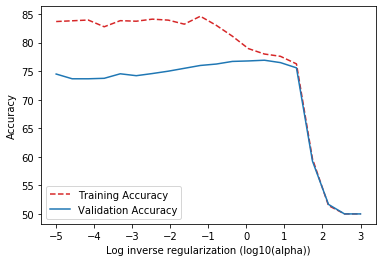

In [114]:
fig, ax = plt.subplots()
ax.plot(A_log,mlp_re.get("mean_train_score")*100, label='Training Accuracy', color="tab:red", ls='--')
ax.plot(A_log,mlp_re.get("mean_test_score")*100, label='Validation Accuracy', color="tab:blue")
plt.xlabel('Log inverse regularization (log10(alpha))')
plt.ylabel('Accuracy')
# plt.ylim([70, 100]);

ax.legend()
plt.show()


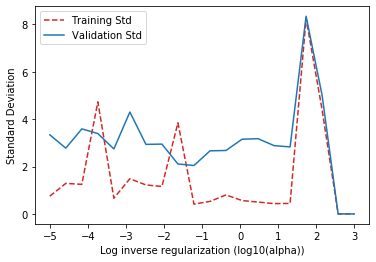

In [115]:
fig, ax = plt.subplots()
ax.plot(A_log,mlp_re.get("std_train_score")*100, label='Training Std', color="tab:red", ls='--')
ax.plot(A_log,mlp_re.get("std_test_score")*100, label='Validation Std', color="tab:blue")
plt.xlabel('Log inverse regularization (log10(alpha))')
plt.ylabel('Standard Deviation')
# plt.ylim([0.0, 0.7]);

ax.legend()
plt.show()


# SVM

In [103]:
param_svm = [{'C': np.logspace(-2, 10, 20)}]

In [104]:
svmclf = GridSearchCV(SVC(kernel='rbf', gamma = 'scale'), param_svm, cv=10, return_train_score=True ).fit(tr_data, y_train_df.values.ravel())


In [105]:
yproba1_test_svm = svmclf.predict(te_data)
np.savetxt('yproba1_testsvm.txt', yproba1_test_svm)

In [106]:
C_grid = np.logspace(-2, 10, 20)
C_log = np.log10(C_grid)
svm_re = svmclf.cv_results_

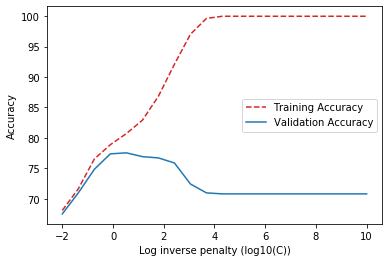

In [107]:
fig, ax = plt.subplots()
ax.plot(C_log,svm_re.get("mean_train_score")*100, label='Training Accuracy', color="tab:red", ls='--')
ax.plot(C_log,svm_re.get("mean_test_score")*100, label='Validation Accuracy', color="tab:blue")
plt.xlabel('Log inverse penalty (log10(C))')
plt.ylabel('Accuracy')
# plt.ylim([70, 100]);

ax.legend()
plt.show()


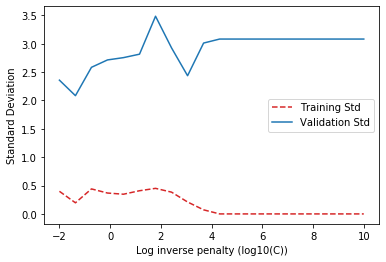

In [108]:
fig, ax = plt.subplots()
ax.plot(C_log,svm_re.get("std_train_score")*100, label='Training Std', color="tab:red", ls='--')
ax.plot(C_log,svm_re.get("std_test_score")*100, label='Validation Std', color="tab:blue")
plt.xlabel('Log inverse penalty (log10(C))')
plt.ylabel('Standard Deviation')
# plt.ylim([0.0, 0.7]);

ax.legend()
plt.show()


In [116]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tr_data, y_train_df, test_size=0.33, random_state=42)

In [123]:
clf = SVC(kernel='rbf', gamma = 'scale', probability=True).fit(X_train, y_train.values.ravel())

In [124]:
yproba1_val = clf.predict_proba(X_val)[:,1]

In [125]:
ypred = [1*(item > 0.5) for item in yproba1_val.tolist()]
yval = y_val['is_positive_sentiment'].tolist()
fp = [(ypred[i] == 1)*(yval[i] == 0) for i in range(len(ypred))]
i_fp = [i for i in range(len(fp)) if fp[i] == 1]
i_fp[0:10]

[3, 14, 31, 61, 63, 73, 102, 124, 128, 133]

In [131]:
x_train_df.iloc[31,:]

website_name            amazon
text            Not impressed.
Name: 31, dtype: object

In [139]:
tr_text_list[133]

'I can barely ever hear on it and am constantly saying "what?"'

In [159]:
ypred = [1*(item > 0.5) for item in yproba1_val.tolist()]
yval = y_val['is_positive_sentiment'].tolist()
fn = [(ypred[i] == 0)*(yval[i] == 1) for i in range(len(ypred))]
i_fn = [i for i in range(len(fn)) if fn[i] == 1]
i_fn[0:10]

[8, 18, 26, 28, 32, 35, 38, 40, 59, 70]

In [167]:
tr_text_list[40]

'Pretty piece of junk.'